In [1]:
import torch
import sys
import os
import numpy as np
from PIL import Image
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F 
sys.path.append(os.path.join(os.getcwd(), 'src'))

import model
import train_loop
import data_loader
import visual
import transformer

/u/09/huttuna6/unix/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_DIR = os.path.join(os.getcwd(), "data")
TARGET_DATA_DIR = os.path.join(DATA_DIR, "target")
LIVECELL_IMG_DIR = os.path.join(DATA_DIR, "livecell", "images")
LIVECELL_MASK_DIR = os.path.join(DATA_DIR, "livecell", "masks")
UNITY_IMG_DIR = os.path.join(DATA_DIR, "unity_data", "images")
UNITY_MASK_DIR = os.path.join(DATA_DIR, "unity_data", "masks")

### liveCell dataset

Next cell creates dataset using only LiveCell dataset and divides dataset to train and test datasets. 

**Do not run this cell if you want to use combination of LivCell and synthetic dataset.**

In [ ]:
dataset = data_loader.MaskedDataset(LIVECELL_IMG_DIR, LIVECELL_MASK_DIR, length=None, in_memory=False)
seed = 123
test_percent = 0.001
n_test = int(len(dataset) * test_percent)
n_train = len(dataset) - n_test
train_set, test_set = random_split(dataset, [n_train, n_test], generator=torch.Generator().manual_seed(123))


### Combined dataset

Next cell creates dataset which combines LiveCell dataset with synthetic dataset and divides dataset to train and test datasets. 

**Do not run this cell if you ran previous code cell to use.**

In [ ]:
LC_dataset = data_loader.MaskedDataset(LIVECELL_IMG_DIR, LIVECELL_MASK_DIR, length=None, in_memory=False)
Unity_dataset = data_loader.MaskedDataset(UNITY_IMG_DIR, UNITY_MASK_DIR, length=None, in_memory=False)
datasets = [LC_dataset, Unity_dataset]
dataset = torch.utils.data.ConcatDataset(datasets)

seed = 123
test_percent = 0.001
n_test = int(len(dataset) * test_percent)
n_train = len(dataset) - n_test
train_set, test_set = random_split(dataset, [n_train, n_test], generator=torch.Generator().manual_seed(123))
    

# UNet 

### Unet training

In this part, you can create neural network and train it. This might take several hours, especially if you do not have GPU. You can change training parameters in `train.net()`.

If you have already trained model, there is no need to run this part.

In [ ]:
neural_net = model.Unet(numChannels=1, classes=2, dropout = 0.1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
neural_net.to(device=device)
neural_net.train()

In [ ]:
train_loop.train_net(   net=neural_net,
                        dataset = train_set,
                        epochs= 1,              # Set epochs
                        batch_size= 2,          # Batch size
                        learning_rate=0.001,    # Learning rate
                        device=device,
                        val_percent=0.1,        # Percent of test set
                        save_checkpoint = True,
                        amp=False)

### Loading model

You can load already trained model from your computer. Write the path to model file in variable `PATH`.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
PATH = ""

In [ ]:
net = torch.load(PATH, map_location=device)

### Visualisation

In [ ]:
visual.imshow_side_by_side_model(1, test_set, net)

In [ ]:
with torch.no_grad():
      image, mask = test_set[1]
      prediction = net(torch.unsqueeze(image, dim=0))
      prediction = torch.squeeze(prediction, dim=0)

In [ ]:
#plt.imshow(torch.squeeze(image), cmap = 'gray')
mask_np = np.delete(prediction.permute(1,2,0).numpy(),0, axis=2)

#mask_np = np.where(mask_np == 0, np.array([0,0,0]), mask_np)
#mask_np = np.where(mask_np == 1, np.array([0,1,0]), mask_np)
plt.imshow(mask_np, alpha = 1)

In [ ]:
plt.imshow(torch.squeeze(image), cmap = 'gray')

In [ ]:
plt.imshow(torch.squeeze(mask))

### Target domain visualisation


In [ ]:
target_set = data_loader.UnMaskedDataset(TARGET_DATA_DIR)

In [ ]:
with torch.no_grad():
      image = target_set[0]
      print(type(image))
      prediction = net(torch.unsqueeze(image, dim=0))
      prediction = torch.squeeze(prediction, dim=0)

In [ ]:
plt.imshow(torch.squeeze(image), cmap = 'gray')
mask_np = np.delete(prediction.permute(1,2,0).numpy(),0, axis=2)

mask_np = np.where(mask_np == 0, np.array([0,0,0]), mask_np)
mask_np = np.where(mask_np == 1, np.array([0,1,0]), mask_np)
plt.imshow(mask_np, alpha = 0.2)

In [ ]:
plt.imshow(torch.squeeze(image), cmap = 'gray')

# Domain Adaptation

## CycleGan

### Load trained model 

If you have allready trained model, you can use this section to load the model.

In [ ]:
from CycleGan import Generator, ResBlock
#from CycleGan_Vol2 import unet_generator, discriminator

In [ ]:
G_A2B_Path = os.path.join(os.getcwd(), "model", "CycleGan_2022-05-05",  "final_50_epochs_with_half_empty_G_A2B.pt" )
G_B2A_Path = os.path.join(os.getcwd(), "model", "CycleGan_2022-05-05", "final_50_epochs_with_half_empty_G_B2A.pt" )

In [ ]:
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G_A2B = torch.load(G_A2B_Path, map_location=device)
G_B2A = torch.load(G_B2A_Path, map_location=device)

### Visualisation

In [ ]:
Target_dataset = data_loader.UnMaskedDataset(TARGET_DATA_DIR, mode=1, IMG_SIZE=256)

seed = 123
target_test_percent = 0.01
n_test_target = int(len(Target_dataset) * target_test_percent)
n_train_target = len(Target_dataset) - n_test_target
target_train_set, target_test_set = torch.utils.data.random_split(Target_dataset, [n_train_target, n_test_target], generator=torch.Generator().manual_seed(seed))

In [ ]:
with torch.no_grad():
      image = target_train_set[0]
      prediction = G_B2A(image)
      prediction2 = G_A2B(prediction)

In [ ]:
prediction = prediction.permute(1,2,0)
prediction2 = prediction2.permute(1,2,0)

In [ ]:
fig = plt.figure(figsize= 2 * np.array(plt.rcParams['figure.figsize']))
plt.subplot(1,3,1)
plt.imshow(torch.squeeze(image), cmap = 'gray')
plt.title("Original target image")
plt.subplot(1,3,2)
plt.imshow(prediction, cmap = 'gray')
plt.title("Shifted domain")
plt.subplot(1,3,3)
plt.imshow(prediction2, cmap = 'gray')
plt.title("domain shifted back to original")
plt.show()

## Transforming test images domain

In [ ]:
import transformer
import matplotlib.image as mpimg

img = mpimg.imread(os.path.join(TARGET_DATA_DIR, "000_0.png"))
Target_dataset = data_loader.UnMaskedDataset(TARGET_DATA_DIR, mode=3)

seed = 123
target_test_percent = 0.01
n_test_target = int(len(Target_dataset) * target_test_percent)
n_train_target = len(Target_dataset) - n_test_target
target_train_set, target_test_set = torch.utils.data.random_split(Target_dataset, [n_train_target, n_test_target], generator=torch.Generator().manual_seed(seed))

model goes whole image through

In [ ]:
block_size = 256

In [ ]:
from torchvision import transforms

image = target_test_set[0]
conver_PIL = transforms.ToPILImage()
convert_Tensor = transforms.ToTensor()
im = conver_PIL(image)
imgwidth, imgheight = im.size
images = []
row = 0
for i in range(0,imgheight,block_size):
    images.append([])
    for j in range(0,imgwidth,block_size):
        box = (j, i, j+block_size, i+block_size)
        a = im.crop(box)
        images[row].append(a)
    row +=1


new_image = Image.new('L', size=(len(images[0])*block_size, len(images)*block_size))
with torch.no_grad():
    for row in range(len(images)):
        i = 0
        for img in images[row]:
        
            prediction = G_B2A(convert_Tensor(img))
            new_image.paste(conver_PIL(prediction), (i*block_size, row*block_size))
            i += 1

new_image = new_image.crop((0,0, 2064, 1544))

In [ ]:
fig = plt.figure(figsize= 3 * np.array(plt.rcParams['figure.figsize']))
plt.subplot(1,2,1)
plt.imshow(im, cmap="gray")
plt.title("Original image")
plt.subplot(1,2,2)
plt.imshow(new_image, cmap="gray")
plt.title("Shifted domain")
plt.show()

## Resize function test

In [ ]:
image = transformer.to_same_size(target_test_set[0], img)

In [ ]:
fig = plt.figure(figsize= 2 * np.array(plt.rcParams['figure.figsize']))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(torch.squeeze(image), cmap = 'gray')
plt.show()

In [ ]:
import torchvision.transforms as T
from PIL import Image
from tqdm import tqdm

LC_dataset = data_loader.MaskedDataset(LIVECELL_IMG_DIR, LIVECELL_MASK_DIR, length=None, in_memory=False, mode=3)
#LC_empty_dataset = data_loader.EmptyLiveCELLDataset(len(LC_dataset), mode = 3)
#LC_datasets = [LC_dataset, LC_empty_dataset]  # 50% empty, 50% actual LiveCELL images
#dataset = torch.utils.data.ConcatDataset(LC_datasets)
dataset = LC_dataset
loader = DataLoader(dataset)
transform = T.ToPILImage()
i = 0
for img, mask in tqdm(loader):
    img, mask = transformer.add_fake_magnetballs(img.squeeze(0), mask.squeeze(0), min_amount = 30, max_amount = 70, max_lightness=0.15)
    img = transform(img.squeeze(0))
    mask = mask.numpy()

    img_path = "/u/09/huttuna6/unix/Documents/LST_GIT/lst-project/data/livecell_magnet_balls/images/" + str(i) + ".tif"
    mask_path = "/u/09/huttuna6/unix/Documents/LST_GIT/lst-project/data/livecell_magnet_balls/masks/" +str(i) + "_mask"
    img.save(img_path)
    np.save(mask_path, mask)
    i +=1


In [ ]:
#LC_dataset = data_loader.MaskedDataset(LIVECELL_IMG_DIR, LIVECELL_MASK_DIR, length=None, in_memory=False, mode=3)
LC_empty_dataset = data_loader.EmptyLiveCELLDataset(3*len(LC_dataset), mode = 3)
#LC_datasets = [LC_dataset, LC_empty_dataset]  # 50% empty, 50% actual LiveCELL images
#dataset = torch.utils.data.ConcatDataset(LC_datasets)
dataset = LC_empty_dataset
loader = DataLoader(dataset)
transform = T.ToPILImage()
i = 0
for img, mask in tqdm(loader):
    img, mask = transformer.add_fake_magnetballs(img.squeeze(0), mask.squeeze(0), min_amount = 30, max_amount = 70, max_lightness=0.15)
    img = transform(img.squeeze(0))
    mask = mask.numpy()

    img_path = "/u/09/huttuna6/unix/Documents/LST_GIT/lst-project/data/empty_lc_magnet_balls/images/" + "empty_" + str(i) + ".tif"
    mask_path = "/u/09/huttuna6/unix/Documents/LST_GIT/lst-project/data/empty_lc_magnet_balls/masks/" +"empty_" + str(i) + "_mask"
    img.save(img_path)
    np.save(mask_path, mask)
    i +=1


# Evaluation

In [3]:
import functions
from torchvision import transforms
from CycleGan import ResBlock, Generator, Discriminator
from tqdm import tqdm
import csv

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_DIR = os.path.join(os.getcwd(), "model")
Unet_LC_mb_mix_path = os.path.join(MODEL_DIR, "Unet_Combined_20epochs_5batch_final.pth")
Unet_LC_mb_path = os.path.join(MODEL_DIR, "Unet_AugmentedLiveCell_20epochs_5batch_final.pth")
Unet_LC_path = os.path.join(MODEL_DIR, "Unet_LiveCell_20epochs_5batch_final.pth")

CG_LC_path = os.path.join(MODEL_DIR, "CycleGan_2022-05-05", "cyclegan_LC_G_B2A.pt")
CG_UN_path = os.path.join(MODEL_DIR, "CycleGan_2022-05-05_2", "cyclegan_unity_G_B2A.pt")
CG_mix_path = os.path.join(MODEL_DIR, "CycleGan_2022-05-05_3", "cyclegan_mix_G_B2A.pt")
CG_LC_e_path = os.path.join(MODEL_DIR, "CycleGan_2022-05-05_4", "cyclegan_lce_G_B2A.pt")
CG_LC_mb_path = os.path.join(MODEL_DIR, "CycleGan_2022-05-05_5", "cyclegan_lc_mb_G_B2A.pt")
CG_LC_mb_e_path = os.path.join(MODEL_DIR, "CycleGan_2022-05-05_6", "cyclegan_lc_mb_e_G_B2A.pt")
CG_LC_mb_mix_path = os.path.join(MODEL_DIR, "CycleGan_2022-05-05_7", "cyclegan_lc_mb_mix_G_B2A.pt")


In [5]:
Unet_LC_mb = model.Unet(numChannels=1, classes=2, dropout = 0.1)
Unet_LC_mb.load_state_dict(torch.load(Unet_LC_mb_path, map_location=torch.device(device)))
Unet_LC_mb_mix = model.Unet(numChannels=1, classes=2, dropout = 0.1)
Unet_LC_mb_mix.load_state_dict(torch.load(Unet_LC_mb_mix_path, map_location=device))
Unet_LC = model.Unet(numChannels=1, classes=2, dropout = 0.1)
Unet_LC.load_state_dict(torch.load(Unet_LC_path, map_location=device))

<All keys matched successfully>

In [6]:
CG_LC_G_B2A = torch.load(CG_LC_path, map_location=device)
CG_UN_G_B2A = torch.load(CG_UN_path, map_location=device)
CG_mix_G_B2A = torch.load(CG_mix_path, map_location=device)
CG_LC_e_G_B2A = torch.load(CG_LC_e_path, map_location=device)
CG_LC_mb_G_B2A = torch.load(CG_LC_mb_path, map_location=device)
CG_LC_mb_e_G_B2A = torch.load(CG_LC_mb_e_path, map_location=device)
CG_LC_mb_mix_G_B2A = torch.load(CG_LC_mb_mix_path, map_location=device)

In [7]:
test_set = data_loader.MaskedDataset(os.path.join(DATA_DIR , "test_target_data", "target_test"), os.path.join(DATA_DIR , "test_target_data", "target_annotations"), mode=3)
test_loader = DataLoader(test_set)

Reading data into memory...


100%|██████████| 15/15 [00:00<00:00, 1099.35it/s]

Dataset initialized!


In [ ]:
from torchvision import transforms
def domain_shift(Generator, image, block_size):
    conver_PIL = transforms.ToPILImage()
    convert_Tensor = transforms.ToTensor()
    im = conver_PIL(image)
    imgwidth, imgheight = im.size
    images = []
    row = 0
    for i in range(0,imgheight,block_size):
        images.append([])
        for j in range(0,imgwidth,block_size):
            box = (j, i, j+block_size, i+block_size)
            a = im.crop(box)
            images[row].append(a)
        row +=1


    new_image = Image.new('L', size=(len(images[0])*block_size, len(images)*block_size))
    with torch.no_grad():
        for row in range(len(images)):
            i = 0
            for img in images[row]:
            
                prediction = Generator(convert_Tensor(img))
                new_image.paste(conver_PIL(prediction), (i*block_size, row*block_size))
                i += 1

    new_image = new_image.crop((0,0, 2064, 1544))
    return convert_Tensor(new_image).unsqueeze(0)

In [ ]:
def create_mask(Generator, image, block_size):
    resize_256 = transforms.Resize((256, 256))
    resize_orig = transforms.Resize((2064, 1544))
    image = resize_256.forward(image)
    conver_PIL = transforms.ToPILImage()
    convert_Tensor = transforms.ToTensor()
    im = conver_PIL(image)
    imgwidth, imgheight = im.size
    images = []
    row = 0
    for i in range(0,imgheight,block_size):
        images.append([])
        for j in range(0,imgwidth,block_size):
            box = (j, i, j+block_size, i+block_size)
            a = im.crop(box)
            images[row].append(a)
        row +=1


    new_image = Image.new('L', size=(len(images[0])*block_size, len(images)*block_size))
    with torch.no_grad():
        for row in range(len(images)):
            i = 0
            for img in images[row]:
            
                prediction = Generator(convert_Tensor(img).unsqueeze(0))
                prediction = (F.softmax(prediction, dim=1)).float()
                prediction = prediction[0,1,:,:]
                new_image.paste(conver_PIL(prediction.squeeze(0)), (i*block_size, row*block_size))
                i += 1

    new_image = new_image.crop((0,0, 2064, 1544))
    return convert_Tensor(new_image).unsqueeze(0)

In [8]:
def make_predictions(Unet, CG, name):
    fig = plt.figure(figsize= 2 * np.array(plt.rcParams['figure.figsize']))
    it = 1
    mask_for_eval =[]
    resize_512 = transforms.Resize((512, 512))
    resize_256 = transforms.Resize((256, 256))
    resize_orig = transforms.Resize((1544, 2064))
    for img, mask in tqdm(test_loader):

        new_img = resize_256.forward(img)
        new_img = CG(new_img)
        new_img = resize_orig(new_img).detach()
        #new_img = domain_shift(CG, img.squeeze(0), 512)
        #new_mask = create_mask(Unet,new_img.squeeze(0), 512)
        new_mask = Unet(resize_256.forward(new_img))
        new_mask = resize_orig.forward(new_mask)
        new_mask = (F.softmax(new_mask, dim=1)).float()
        new_mask = new_mask[0,1,:,:].unsqueeze(0).detach()
    
    

        mask_for_eval.append((mask, new_mask))
        plt.subplot(1,4,1)
        plt.imshow(img.squeeze(0).permute((1,2,0)), cmap = 'gray')
        plt.title("Original image")
        plt.subplot(1,4,2)
        plt.imshow(new_img.squeeze(0).permute((1,2,0)), cmap = 'gray')
        plt.title("Shifted domain")
        plt.subplot(1,4,3)
        plt.imshow(mask.permute((1,2,0)), cmap = 'gray')
        plt.title("True mask")
        plt.subplot(1,4,4)
        plt.imshow(new_mask.permute((1,2,0)), cmap = 'gray')
        plt.title("Predicted mask")
        fig.tight_layout()
        savepath = os.path.join(os.getcwd(),"model", "images", name, str(it) +".svg")
        plt.savefig(savepath, format="svg")
        it += 1
    
    return mask_for_eval
    

In [9]:
def evaluate(mask_list, name):
    scores = [name]
    for mask, prediction in tqdm(mask_list):
        score = functions.dice_loss(mask, prediction)
        scores.append(score.item())
    scores.append((sum(scores[1:])/15))
    f = open(os.path.join(os.getcwd(),"model", "images", "losses.csv"), 'a')
    writer = csv.writer(f)
    writer.writerow(scores)
    f.close()

100%|██████████| 15/15 [00:00<00:00, 386.49it/s]


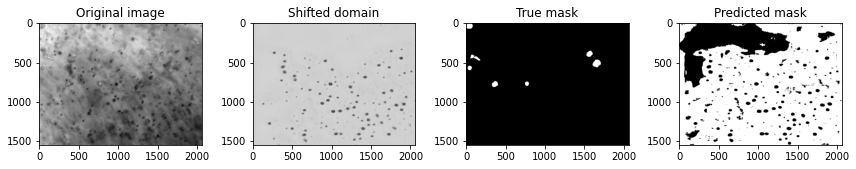

In [10]:
LC_mb_masks = make_predictions(Unet_LC_mb, CG_LC_mb_G_B2A, "LC_mb")
evaluate(LC_mb_masks, "LC_mb")

100%|██████████| 15/15 [00:00<00:00, 70.01it/s]


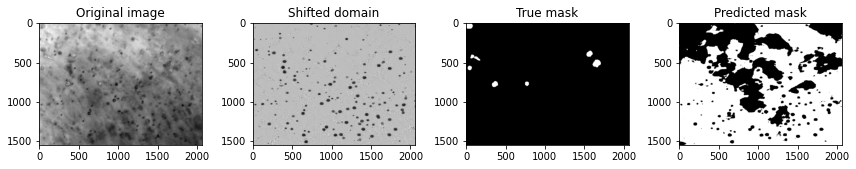

In [11]:
LC_mb_e_mask = make_predictions(Unet_LC_mb, CG_LC_mb_e_G_B2A, "LC_mb_e")
evaluate(LC_mb_e_mask, "LC_mb_e")

100%|██████████| 15/15 [00:00<00:00, 756.92it/s]


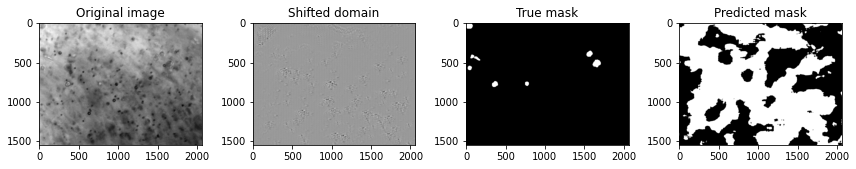

In [12]:
LC_mask =make_predictions(Unet_LC, CG_LC_G_B2A, "LC")
evaluate(LC_mask, "LC")

100%|██████████| 15/15 [00:00<00:00, 242.97it/s]


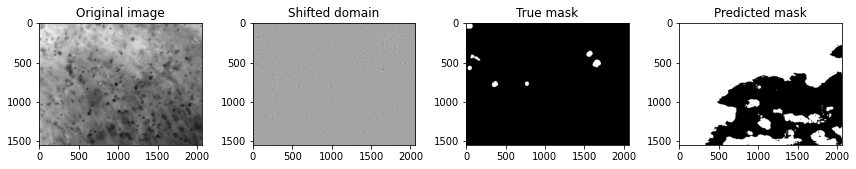

In [13]:
LC_e_mask = make_predictions(Unet_LC,CG_LC_e_G_B2A, "LC_e")
evaluate(LC_e_mask, "LC_e")

100%|██████████| 15/15 [00:00<00:00, 563.64it/s]


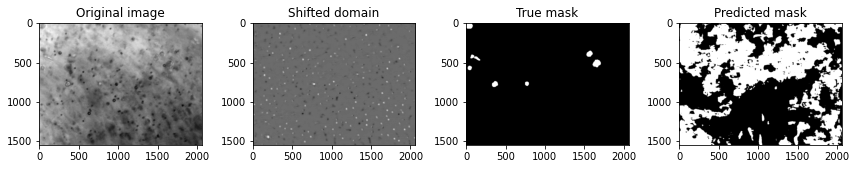

In [10]:
LC_mb_mix_mask = make_predictions(Unet_LC_mb_mix, CG_LC_mb_mix_G_B2A, "LC_mb_mix")
evaluate(LC_mb_mix_mask, "LC_mb_mix")